## Carbon-I Testbed Prototype

A prototype instrument has already been developed at JPL to demonstrate the Carbon-I measurement concept. This **testbed** incorporates a Dyson block, grating, and focal-plane array (FPA) matching Carbon-I’s anticipated optical design and performance specifications. Through laboratory measurements, the testbed can validate key elements such as **spectral resolution**, **imaging fidelity**, **throughput**, and **straylight** characteristics. These  demonstrations can confirm that Carbon-I’s architecture is both **technically feasible** and **robust**, ensuring confidence as we proceed toward a flight-ready instrument. 

In its current setup, the **testbed spectra** are measured under a **warm environment**, so the system is not fully aligned at flight operating temperatures. Consequently, the **spectral response function (SRF)** in these early demonstrations will appear more **fuzzy** than what we expect under cold, flight-like alignment conditions—a refinement that will be investigated in subsequent testbed campaigns.

---

Below, we walk through the **testbed-spectra fitting** procedure using measurements from a **light source** paired with a **CH<sub>4</sub> gas cell**. All examples here leverage the **Julia** programming language, chosen for its **high-level syntax** and **near-C speed**, making it ideally suited for the **Carbon-I** data processing pipeline. 

> First, we need to import some packages in Julia

In [2]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM
# Using standard Julia packages for Linear albegra, Differentiation, etc.
using SpecialPolynomials, FiniteDiff, LinearAlgebra
using DelimitedFiles, ImageFiltering, ForwardDiff, DiffResults
# Using the Makie package for plotting
using CairoMakie
include(joinpath("../../src/Plots", "CI_colorsNew.jl"))

  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/.julia/packages/vSmartMOM/a7WZC/src/vSmartMOM.jl:59


pwd()

> Reading in the testbed spectra, stored as simple CSV file:

In [13]:
testbed_ch4 = readdlm("../../data/CITB/20250318-CITB-Methane.csv",',');
testbed_co = readdlm("../../data/CITB/20250318-CITB-CO.csv",',');
testbed_c2h6 = readdlm("../../data/CITB/20250318-CITB-C2H6.csv",',');

In [14]:
set_theme!(theme_ggplot2())

In [17]:
function plotSpectra()
    f = Figure(resolution = (800, 600))
    
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
    
    lines!(ax,  testbed_ch4[:,1],testbed_ch4[:,2], color = CarbonI_colors[1], linewidth = 2.0, label = "CH₄ gas cell")
    lines!(ax,  testbed_co[:,1],testbed_co[:,2], color = CarbonI_colors[3], linewidth = 2.0, label = "CO gas cell")
    lines!(ax,  testbed_c2h6[:,1],testbed_c2h6[:,2], color = CarbonI_colors[5], linewidth = 2.0, label = "C₂H₆ gas cell")
    axislegend(ax,position = :lb)
    f
end

plotSpectra (generic function with 1 method)

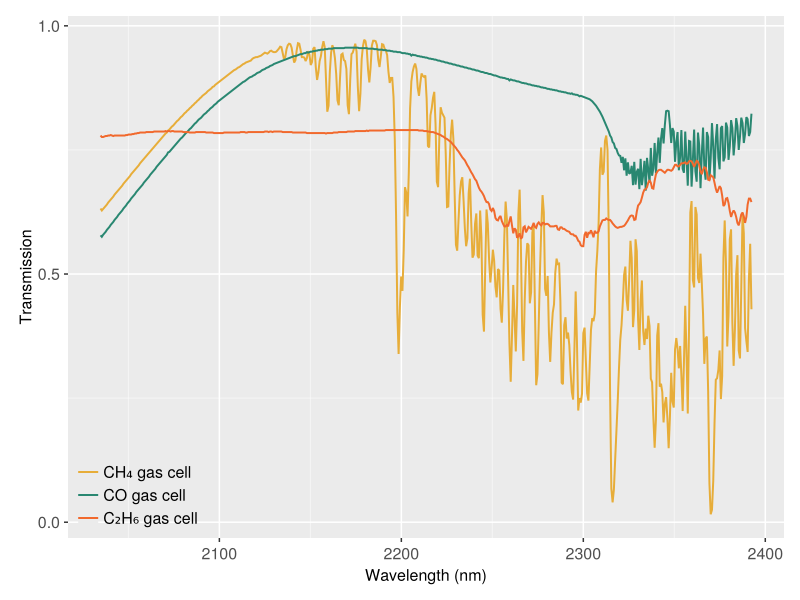

In [18]:
plotSpectra()

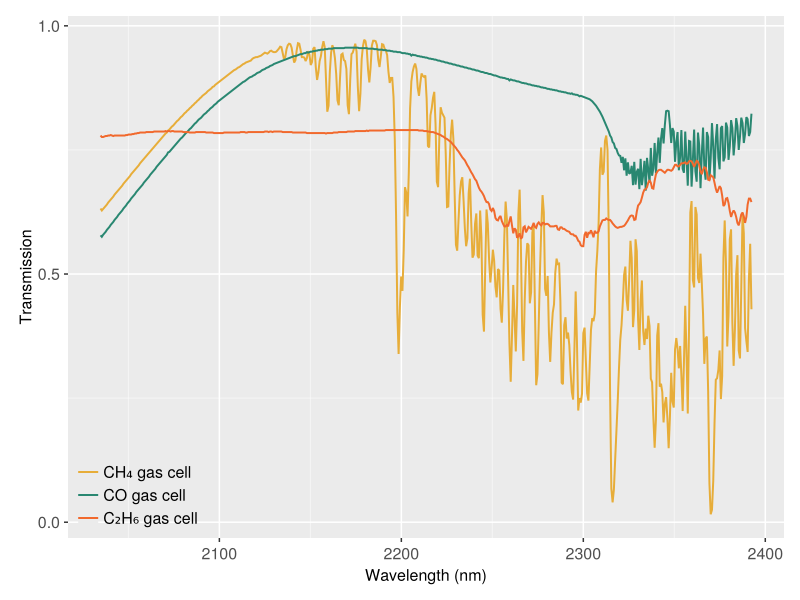

In [ ]:
plotSpectra()